# Charting: RateYourMusic Exploratory Data Analysis and Recommendations

![](http://image-cdn-ak.spotifycdn.com/image/ab67706c0000da84ac2ff5f80eab1f1253fdd851)

[Rate Your Music](http://rateyourmusic.com/) is one of my favourite websites, and I often visit it for music discovery.
A dataset for the 5000 most reviewed albums is available [here](http://www.kaggle.com/datasets/tobennao/rym-top-5000) and I absolutely had to work with it and see what interesting things I could find! This work aims to lead to some interesting music discovery - albums/ artists/ genres to check out. As well as a greater understanding of music preferences, music itself and the music industry. Along side this, I believe this data could be used in business contexts; what music record shops should stock, what artists venues should book, etc.

My analysis was massively helped by another kaggle user, who wrote a similar [notebook](http://www.kaggle.com/code/jbfriedli/a-deep-dive-into-the-rym-top-5000-albums) a few years ago. Looking at their work was particularly instructive for dealing with list-likes (genre and descriptor columns). Section 1 follows along with their work, but adds some further detail, and section 3 is a retread of their work, but thought it interesting to include (different programming also)...

The Notebook is split into sections focussed on different analysis:

***Opinion Focussed***

**1. Finding Favorites**
- Ranking of music features with respect to opinion features
- **Recommendations:** RYM's favourite music in different categories
    
    
**2. Trends in Preferences**
- What types of music are seen to have improved/worsened over time
    - Artists/genres and descriptors
- Which artist has the most inconsistent&/consistent catalogue according to users
- **Recommendations:** Categories of music to look out for future releases of based on their trend in rating

***Music Focussed***

**3. Trends in Types of Music**
- How types of music have become more/ less prevalent over time
    - genres and descriptors
- What types of music are most prevalent each year
- **Recommendations:** Years to look for more music based on the years when your favourite kind of music was being released
    
**4. Co-occurrences**
- Genres/descriptors that are most often combined
- Genres that occur most with each descriptor and vice verse
- **Recommendations:** Types of music that are often prevalent with your favourites   
 
    
**5. Release Scheduling**
- When do albums tend to be released?
    - Has this changed over time?
- **Recommendations:** When to look out for new music


# 0) Setup

### Importing Packages

In [55]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression


import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, message=".*missing from current font.*")

### Preprocessing Dataset

In [56]:
#loading
df = pd.read_csv('/kaggle/input/rym-top-5000/rym_clean1.csv', index_col = 'position')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df_og = df.copy()

#datetimes
df.release_date = pd.to_datetime(df.release_date)
df['year'] = df.release_date.dt.year
df['month'] = df.release_date.dt.strftime('%b')
df['monthday'] = df.release_date.dt.day
df['weekday'] = df.release_date.dt.strftime('%a')


#listlikes
df['pg_nf'] = df.primary_genres.fillna('')
df['sg_nf'] = df.secondary_genres.fillna('')
df['primary_genres'] = (df.pg_nf.str.strip(', ').str.replace(', ',',').str.split(','))
df['secondary_genres'] = ((df.sg_nf).str.strip(', ').str.replace(', ',',').str.split(','))
df['genres'] = ((df.pg_nf + ', ' + df.sg_nf).str.strip(', ').str.replace(', ',',').str.split(','))
df['descriptors'] = df.descriptors.str.replace(',...','').str.split(', ')

#organising
df.drop(['release_type','pg_nf','sg_nf'],axis = 1, inplace= True)
df = df[['release_name','artist_name','genres','descriptors','release_date','year','month','monthday','weekday',\
         'rating_count','review_count','avg_rating']]

### Changes
* Extracted all possible datetime features
* Written genres and descriptors in a more manageable format
* Discarded primary and secondary genres (for brevity of already lengthy analysis)

See changes in structure bellow:

In [57]:
print('Original Dataset:\n')
display(df_og.head(1))
print('\nProcessed Dataset:\n')
df.head(1)

Original Dataset:



,release_name,artist_name,release_date,release_type,primary_genres,secondary_genres,descriptors,avg_rating,rating_count,review_count
position,,,,,,,,,,
1,OK Computer,Radiohead,1997-06-16,album,"Alternative Rock, Art Rock",NaN,"melancholic, anxious, futuristic, malevocals, ...",4.24,74027,1541



Processed Dataset:



,release_name,artist_name,genres,descriptors,release_date,year,month,monthday,weekday,rating_count,review_count,avg_rating
position,,,,,,,,,,,,
1,OK Computer,Radiohead,"[Alternative Rock, Art Rock]","[melancholic, anxious, futuristic, malevocals,...",1997-06-16,1997,Jun,16,Mon,74027,1541,4.24


#### **NB: Error With Artist Names on Certain Collaborative Releases eg...**

In [ ]:
df_error = pd.read_csv('/kaggle/input/rym-top-5000/rym_clean1.csv', index_col = 'position')
df_error.drop('Unnamed: 0', axis = 1, inplace = True)

df_error[df_error['artist_name'] == 'Colin Stetson and Sarah NeufeldColin StetsonSarah Neufeld'].loc[:,'artist_name'].values[0]

This never affects my work, but is worth noting.

# 1) Finding Favourites

Music recommendations by finding RYMs favourites albums, artists, genres and descriptors.

Ranking albums, artists, genres and descriptors by different metrics: number of ratings, reviews and average rating (and number of albums for grouped data) 
which shows us new music we can listen to!

## Albums

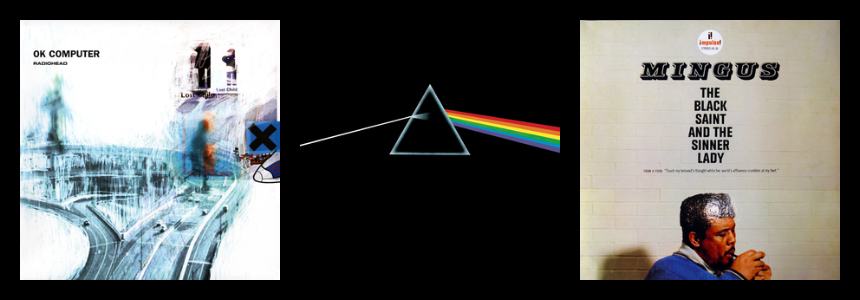

Most Rated: **OK Computer**

Most Reviewed: **Dark Side of the Moon**

Highest Average Rating: **The Black Saint and the Sinner Lady**

In [ ]:
#writing a colour palette for albums...

albums = list(set(df[['release_name','avg_rating']].sort_values('avg_rating',ascending=False).head(10).release_name.to_list() + \
df[['release_name','review_count']].sort_values('review_count',ascending=False).head(10).release_name.to_list() + \
df[['release_name','rating_count']].head(10).release_name.to_list()))

colours = sns.color_palette('hls', len(albums))

mypal = dict(zip(albums,colours))

mypal.update({'The Rise and Fall of Ziggy...':(0.86,0.5197714285714286,0.33999999999999997)})
# mypal

#First plot!!!
#top ten by number of ratings
sns.barplot(df[['release_name','rating_count']].head(10), y = 'release_name', x = 'rating_count', palette = mypal)
plt.ylabel('Album')
plt.xlabel('No. Ratings')
plt.title('Most Rated Albums')
plt.xlim(40000, 75000);

In [ ]:
#top ten by number of reviews
sns.barplot(df[['release_name','review_count']].sort_values('review_count',ascending=False).head(10),\
            y = 'release_name', x = 'review_count', palette = mypal)
plt.ylabel('Album')
plt.xlabel('No. Reviews')
plt.title('Most Reviewed Albums')
plt.xlim(800, 1600);

In [ ]:
#rewriting album name for graph redability
ratings = df[['release_name','avg_rating']].sort_values('avg_rating',ascending=False).head(10)
ratings.loc[18, 'release_name'] = 'The Rise and Fall of Ziggy...'

#top ten by average rating
sns.barplot(ratings, y = 'release_name', x = 'avg_rating', palette = mypal)
plt.ylabel('Album')
plt.xlabel('Average Rating')
plt.title('Highest Rated Albums')
plt.xlim(4.2, 4.35);

## Artists

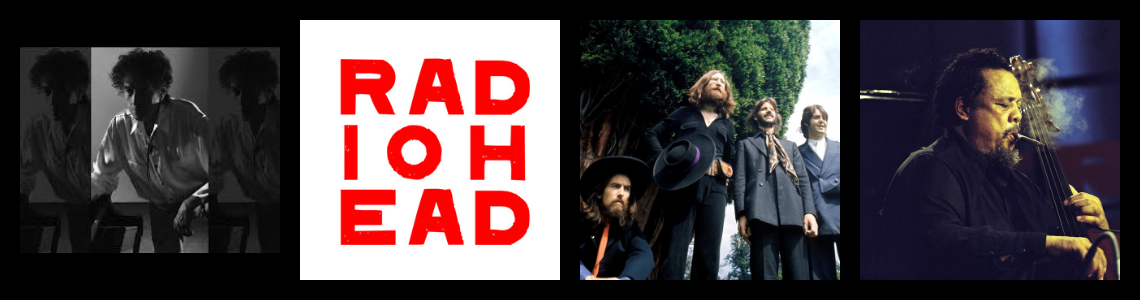

Most Entries: **Bob Dylan**

Most Ratings: **Radiohead**

Most Reviews: **The Beatles**

Highest Average Rating: **Mingus**

In [ ]:
#Create a groupby with all the plotting data
ar_grp = df.groupby('artist_name')[['rating_count',\
                                    'review_count',\
                                    'avg_rating']].agg({'rating_count':['count','sum'],\
                                                        'review_count':'sum',\
                                                        'avg_rating':'mean',})

ar_grp = ar_grp.droplevel(1,axis=1)
ar_grp.columns = ['n_albums','rating_count','review_count', 'avg_rating']
ar_grp.reset_index(inplace = True)

#create a colour palette for artists
artists = list(set(ar_grp.sort_values('n_albums',ascending=False).head(10).artist_name.to_list()+\
ar_grp.sort_values('rating_count',ascending=False).head(10).artist_name.to_list()+\
ar_grp.sort_values('review_count',ascending=False).head(10).artist_name.to_list()+\
ar_grp.sort_values('avg_rating',ascending=False).head(10).artist_name.to_list()))

colours = sns.color_palette('hls',len(artists))
pal = dict(zip(artists,colours))


#First plot!!
sns.barplot(ar_grp.sort_values('n_albums',ascending=False).head(10), x = 'n_albums', y = 'artist_name',\
           palette = pal)
plt.ylabel('Artist')
plt.xlabel('No. Albums')
plt.title('Artists with the Most Albums');
plt.xlim(10,26);

In [ ]:
sns.barplot(ar_grp.sort_values('rating_count',ascending=False).head(10), x = 'rating_count', y = 'artist_name',\
           palette = pal)
plt.ylabel('Artist')
plt.xlabel('No. Albums')
plt.title('Artists with the Most Ratings');

In [ ]:
sns.barplot(ar_grp.sort_values('review_count',ascending=False).head(10), x = 'review_count', y = 'artist_name',\
           palette = pal)
plt.ylabel('Artist')
plt.xlabel('No. Reviews')
plt.title('Artists with the Most Reviews');

In [ ]:
sns.barplot(ar_grp.sort_values('avg_rating',ascending=False).head(10), x = 'avg_rating', y = 'artist_name',\
           palette = pal)
plt.ylabel('Artist')
plt.xlabel('Average Rating')
plt.xlim(4.05,4.35)
plt.title('Artists with the Highest Average Rating');

*Each has very few entries - maybe worth setting a limit of n albums*

## Genres

Most entries: **Singer-Songwriter**

Most Ratings: **Art Rock**

Most Reviews: **Alternative Rock**

Highest Average Rating: **Mexican Music**


In [ ]:
#create a groupby of plotting data
ge_grp = df.explode('genres').groupby('genres')[['genres',\
                                                 'rating_count',\
                                                 'review_count',\
                                                 'avg_rating']].agg({'genres':'count',\
                                                                     'rating_count': 'sum',\
                                                                     'review_count':'sum',\
                                                                     'avg_rating':'mean'})

ge_grp.rename({'genres':'n_albums'}, axis=1, inplace = True)
ge_grp.reset_index(inplace = True)

#create a colour palette for genres
genres = list(set(ge_grp.sort_values('n_albums', ascending=False).head(10).genres.to_list() +\
ge_grp.sort_values('rating_count', ascending=False).head(10).genres.to_list() +\
ge_grp.sort_values('review_count', ascending=False).head(10).genres.to_list() +\
ge_grp.sort_values('avg_rating', ascending=False).head(10).genres.to_list()))

colours = sns.color_palette('hls',len(genres))

pal = dict(zip(genres, colours))

#First plot!!!
sns.barplot(ge_grp.sort_values('n_albums', ascending=False).head(10), x = 'n_albums',y= 'genres',\
           palette = pal)
plt.title('Genres with Most Albums')
plt.ylabel('Genre')
plt.xlabel('No. Albums')
plt.xlim(250,430);

In [ ]:
sns.barplot(ge_grp.sort_values('rating_count', ascending=False).head(10), x = 'rating_count',y= 'genres',\
           palette = pal)
plt.title('Genres with Most Ratings')
plt.ylabel('Genre')
plt.xlabel('No. Ratings')
plt.xlim(1.5e6,3e6);

In [ ]:
sns.barplot(ge_grp.sort_values('review_count', ascending=False).head(10), x = 'review_count',y= 'genres',\
           palette = pal)
plt.title('Genres with Most Reviews')
plt.ylabel('Genre')
plt.xlabel('No. Reviews')
plt.xlim(3e4,6e4);

In [ ]:
sns.barplot(ge_grp.sort_values('avg_rating', ascending=False).head(10), x = 'avg_rating',y= 'genres',\
           palette = pal)
plt.title('Genres with Highest Average Rating')
plt.ylabel('Genre')
plt.xlabel('Average Rating')
plt.xlim(3.95,4.15);

*Each has very few entries - maybe worth setting a limit of n albums*

## Descriptors

Most Entries: **malevocals**

Most Ratings: **malevocals**

Most Reviews: **malevocals**

Highest Average Rating: **Christmas Music**

This one is less interesting, the overwhelming prevalence of malevocals (>3/5 of the data) makes it a landslide win.

In [ ]:
#groupby for genre plotting data
de_grp = df.explode('descriptors').groupby('descriptors')[['descriptors',\
                                                          'rating_count',\
                                                          'review_count',\
                                                          'avg_rating']].agg({'descriptors':'count',\
                                                                              'rating_count':'sum',\
                                                                              'review_count':'sum',\
                                                                              'avg_rating':'mean'})

de_grp.rename({'descriptors':'n_albums'},axis=1,inplace=True)
de_grp.reset_index(inplace = True)

#writing a colour palette for descriptors
descriptors = list(set(de_grp.sort_values('n_albums',ascending=False).head(10).descriptors.to_list() +\
de_grp.sort_values('rating_count',ascending=False).head(10).descriptors.to_list() +\
de_grp.sort_values('review_count',ascending=False).head(10).descriptors.to_list() +\
de_grp.sort_values('avg_rating',ascending=False).head(10).descriptors.to_list()))

colours = sns.color_palette('hls',len(descriptors))

pal = dict(zip(descriptors,colours))

#First plot!!!
sns.barplot(de_grp.sort_values('n_albums',ascending=False).head(10),x='n_albums',y='descriptors',\
           palette = pal)
plt.title('Descriptors with Most Albums')
plt.ylabel('Descriptors')
plt.xlabel('No. Albums');

In [ ]:
sns.barplot(de_grp.sort_values('rating_count',ascending=False).head(10),x='rating_count',y='descriptors',\
           palette = pal)
plt.title('Descriptors with Most Ratings')
plt.ylabel('Descriptors')
plt.xlabel('No. Ratings');

In [ ]:
sns.barplot(de_grp.sort_values('review_count',ascending=False).head(10),x='review_count',y='descriptors',\
           palette = pal)
plt.title('Descriptors with Most Reviews')
plt.ylabel('Descriptors')
plt.xlabel('No. Reviews');

In [ ]:
sns.barplot(de_grp.sort_values('avg_rating',ascending=False).head(10),x='avg_rating',y='descriptors',\
           palette = pal)
plt.title('Descriptors with Highest Rating')
plt.ylabel('Descriptors')
plt.xlabel('Avg. Rating')
plt.xlim(3.65,3.95);

*Each has very few entries - maybe worth setting a limit of n albums*

## Years

Most Entries: **2018**

Most Ratings: **2018**

Most Reviews: **1994**

Highest Average Rating: **1961**

In [ ]:
#create a groupby of plotting data
yr_grp = df.groupby('year')[['year',\
                             'review_count',\
                             'rating_count',\
                             'avg_rating']].agg({'year':'count',\
                                                 'review_count':'sum',\
                                                 'rating_count':'sum',\
                                                 'avg_rating':'mean'})

yr_grp.rename({'year':'n_albums'},axis=1,inplace = True)
yr_grp.reset_index(inplace=True)
# yr_grp.year = yr_grp.year.astype(str)

sns.histplot(yr_grp, x = 'year', weights = 'n_albums', bins = len(yr_grp),hue = 'n_albums', palette='viridis', legend=False)
plt.title('Number of Albums released in each Year')
plt.ylabel('No. Albums')
plt.xlabel('Year');

In [ ]:
sns.histplot(yr_grp, x = 'year', weights = 'rating_count', bins = len(yr_grp),\
             hue = 'rating_count', palette='mako', legend=False)
plt.title('Number of Ratings for Albums Released in each Year')
plt.ylabel('No. Ratings')
plt.xlabel('Year');

In [ ]:
sns.histplot(yr_grp, x = 'year', weights = 'review_count', bins = len(yr_grp),\
             hue = 'review_count', palette='rocket', legend=False)
plt.title('Number of Reviews for Albums Released in each Year')
plt.ylabel('No. Reviews')
plt.xlabel('Year');

In [ ]:
sns.scatterplot(data=yr_grp, x='year',y='avg_rating')
sns.lineplot(data=yr_grp, x='year',y='avg_rating')
plt.xlabel('Year')
plt.ylabel('Average rating')
plt.title('Average Rating by Year');

Yearly mean Album Rating was descreasing over time, but has started increasing since about 2018!


Users perceive music to have gotten worse over time until very recently!?

# 2) Trends in Preference

Music recommendations by finding positive trends in average ratings of artist, genre and descriptor catalogues.

How RYM believes music of different types has changed in quality over time. Fitting a linear regression to artists, genres and descriptor data with respect to user ratings finding, those that trend up (and down since it's also interesting) over time.

features which are trending in a positive directions we should look for future releases of for good music to look forward to!

## Whole Dataset

Now fitting a trend rather than looking at means, we again see Average rating is tending down:

In [ ]:
lr = LinearRegression()
lr.fit(X=df[['year']], y = df[['avg_rating']])
grad = lr.coef_[0][0]

sns.lmplot(df, x='year',y='avg_rating', scatter_kws={'alpha':0.1}, height=4, aspect = 1.5)
plt.title('Album Rating by Year')
plt.xlabel('Year')
plt.ylabel('Rating')
print(f'Fit Slope: {grad}')

Plotting categories of music against this to see how they perform, and what we should keep and eye on for future releases:

## Artists

Most Positive Rating Trend: **Talk Talk**

Most Negative Rating Trend: **The Clash**

*Arbitrary choice of artists with five or more albums.*

In [ ]:
# Construct a dataframe containing an estimation of artist rating trend and no. albums
artists = df.artist_name.value_counts()[df.artist_name.value_counts()>=5].index.to_list()
ar_dic = {}

for artist in artists:
    
    artist_df = df[df.artist_name == artist]
    lr = LinearRegression()
    lr.fit(X=artist_df[['year']],y=artist_df[['avg_rating']])
    ar_dic[artist] = [lr.coef_[0][0], len(artist_df)]
    
ar_df = pd.DataFrame(ar_dic, index = [0,1]).T
ar_df.rename({0:'Fit Slope',1:'No. Albums'}, axis=1, inplace = True)
ar_df = ar_df.sort_values('Fit Slope', ascending=False)

print('Best Trends:')
display(ar_df.head())
print('Worst Trends:')
ar_df.tail()

In [ ]:
#plot an artists' rating trend against the whole dataset

def plot_artist(choosen_artist):
    dfn= df.copy()
    dfn[choosen_artist] = df['artist_name'] == choosen_artist
    sns.lmplot(dfn,y= 'avg_rating',x='year', scatter_kws={'alpha':0.2}, hue = choosen_artist, height=4, aspect = 1.5)
    plt.title(f"'{choosen_artist}' Rating Trend")
    plt.ylabel('Average Rating')
    plt.xlabel('Year');
    
plot_artist('Talk Talk')
plot_artist('The Clash')

## Genres

Most Positive Rating Trend: **Noise**

Most Negative Rating Trend: **Trap**

*Arbitrary choice of genres with fifty or more albums.*

In [ ]:
# Construct a dataframe containing an estimation of artist rating trend and no. albums
genres = df.genres.explode().value_counts()[df.genres.explode().value_counts()>=50].index.to_list()
gr_dic = {}

for genre in genres:
    
    genre_df = df[df.genres.apply(lambda x: genre in x)]
    lr = LinearRegression()
    lr.fit(X=genre_df[['year']],y=genre_df[['avg_rating']])
    gr_dic[genre] = [lr.coef_[0][0], len(genre_df)]
    
gr_df = pd.DataFrame(gr_dic, index = [0,1]).T
gr_df.rename({0:'Fit Slope', 1:'No. Albums'}, axis=1, inplace=True)
gr_df = gr_df.sort_values('Fit Slope', ascending=False)


print('Best Trends:')
display(gr_df.head())
print('Worst Trends:')
gr_df.tail()

In [ ]:
#plot an artists' rating trend against the whole dataset
def plot_genre(choosen_genre):
    dfn= df.copy()
    dfn[choosen_genre] = df['genres'].apply(lambda x: choosen_genre in x)
    sns.lmplot(dfn,y= 'avg_rating',x='year', scatter_kws={'alpha':0.2}, hue = choosen_genre, height=4, aspect = 1.5)
    plt.title(f"'{choosen_genre}' Rating Trend")
    plt.ylabel('Average Rating')
    plt.xlabel('Year');
    
plot_genre('Noise')
plot_genre('Trap')

## Descriptors

Most Positive Rating Trend: **pastoral**

Most Negative Rating Trend: **self-hatred**

*Arbitrary choice of descriptors with fifty or more albums.*

In [ ]:
# Construct a dataframe containing an estimation of artist rating trend and no. albums
descriptors = df.descriptors.explode().value_counts()[df.descriptors.explode().value_counts()>=50].index.to_list()
dr_dic = {}

for desc in descriptors:
    
    desc_df = df[df.descriptors.apply(lambda x: desc in x)]
    lr = LinearRegression()
    lr.fit(X=desc_df[['year']],y=desc_df[['avg_rating']])
    dr_dic[desc] = [lr.coef_[0][0], len(desc_df)]
    
dr_df = pd.DataFrame(dr_dic, index = [0,1]).T
dr_df.rename({0:'Fit Slope',1:'No. Albums'}, axis=1, inplace = True)
dr_df = dr_df.sort_values('Fit Slope', ascending=False)

print('Best Trends:')
display(dr_df.head())
print('Worst Trends:')
dr_df.tail()

In [ ]:
#plot an descriptor's rating trend against the whole dataset
def plot_desc(choosen_desc):
    dfn= df.copy()
    dfn[choosen_desc] = df['descriptors'].apply(lambda x: choosen_desc in x)
    sns.lmplot(dfn,y= 'avg_rating',x='year', scatter_kws={'alpha':0.2}, hue = choosen_desc, height=4, aspect = 1.5)
    plt.title(f"'{choosen_desc}' Rating Trend")
    plt.ylabel('Average Rating')
    plt.xlabel('Year');
    
plot_desc('pastoral')
plot_desc('self-hatred')

### Most Polarised and Consistent Artist Catalogues

Most polarised catalogue: **Eminiem**

Most consistent catalogue: **ABBA**

*Arbitrary choice of 5 or more albums per artist*

In [ ]:
artists = df.artist_name.value_counts()[df.artist_name.value_counts()>=5].index.to_list()

ap_dic = {}

for artist in artists:
    ar_df = df[df['artist_name'] == artist]
    worst = ar_df.loc[ar_df.avg_rating.idxmin(), 'release_name']
    best = ar_df.loc[ar_df.avg_rating.idxmax(), 'release_name']
    diff = ar_df.avg_rating.max() - ar_df.avg_rating.min()
    ap_dic[artist] = [diff, len(ar_df), best, worst]
    
ap_df = pd.DataFrame(ap_dic).T
ap_df.rename({0:'Max-Min Rating',1:'No. Albums',2:'Highest Rated Album', 3:'Lowest Rated Album'}, axis=1, inplace = True)
ap_df = ap_df.sort_values('Max-Min Rating', ascending=False)

print('Most polarised catalogues:')
display(ap_df.head())
print('Most consistent catalogues:')
display(ap_df.tail())

In [ ]:
def plot_artrend(artist):
    art_df = df[df['artist_name'] == artist]
    sns.lineplot(art_df, x = 'year',y='avg_rating')
    sns.scatterplot(art_df, x = 'year', y='avg_rating')
    plt.title(f"'{artist}' Album Ratings")
    plt.ylabel('Average Rating')
    plt.xlabel('Year');

plot_artrend('Eminem')
plt.ylim(0,5)
plt.figure()
plot_artrend('ABBA')
plt.ylim(0,5);

# 3) Trends in Types of Music

Music recommendations by finding when your favourite type of music was more prevalent.

Time series data of the prevalence of types of music over time and when there were more albums of certain genres/ descriptors.

By looking at the time series, you can find periods of time in which you are likely to find more music you enjoy!

## Genres

In [ ]:
genres = df.genres.explode().value_counts()[:5].index
ge_ts_tot=pd.DataFrame()
genre_tot =[]

for genre in genres:
    ge_df = df[df.genres.apply(lambda x:genre in x)]
    ge_ts_ser = ge_df.groupby('year')['genres'].count()
    ge_ts_ser.rename(str(genre), inplace=True)
    genre_tot.append(ge_ts_ser)

plt.figure(figsize=(12,4))
sns.lineplot(genre_tot)
plt.title('Prevalence of Popular Genres Over Time')
plt.ylabel('No. Albums')
plt.xlabel('Year');

### Most Prevalent Genre Each Year:

In [ ]:
years = sorted(list(df.year.unique()))
year_gen_dict = {}
for year in years:
    year_df = df[df['year'] == year]
    year_df = year_df.explode('genres')
    genre = year_df.genres.value_counts().index[0]
    counts = year_df.genres.value_counts()[0]
    year_gen_dict[year] = [genre, counts]
    
gen_year = pd.DataFrame(year_gen_dict).T
gen_year.rename({0:'Genre',1:'No. Albums'}, axis=1, inplace = True)
gen_year

## Descriptors

In [ ]:
descriptors = df.descriptors.explode().value_counts()[:5].index
de_ts_tot=pd.DataFrame()
desc_tot =[]

for desc in descriptors:
    de_df = df[df.descriptors.apply(lambda x:desc in x)]
    de_ts_ser = de_df.groupby('year')['descriptors'].count()
    de_ts_ser.rename(str(desc), inplace=True)
    desc_tot.append(de_ts_ser)
    
desc_tot = pd.DataFrame(desc_tot).T

plt.figure(figsize=(12,4))
sns.lineplot(desc_tot)
plt.title('Prevalence of Popular Descriptors over Time')
plt.ylabel('No. Albums')
plt.xlabel('Year');

### Most Prevalent Descriptor Each Year:

In [ ]:
year_desc_dict = {}
for year in years:
    year_df = df[df['year'] == year]
    year_df = year_df.explode('descriptors')
    desc = year_df.descriptors.value_counts().index[0]
    counts = year_df.descriptors.value_counts()[0]
    year_desc_dict[year] = [desc, counts]
    
desc_year = pd.DataFrame(year_desc_dict).T
desc_year.rename({0:'Descriptor',1:'No. Albums'}, axis=1, inplace = True)
desc_year

# 4) Co-occurrences

Music recommendations by finding genres that occur together frequently.

If you like one genre/descriptor, maybe try looking into one it pairs with often too?

## Genres

Most Prevalent Genre Pairing: **Pop Rap & Trap**

Most Prevalent Genre Pairing (in the ten most prevalent genres): **Pop Rock & Alternative Rock**

In [ ]:
genres = df.genres.explode().value_counts().index.to_list()

genre_matrix = pd.DataFrame(
    {genre: df['genres'].apply(lambda x: 1 if genre in x else 0) for genre in genres}
)

cooc = genre_matrix.T.dot(genre_matrix)

cols = cooc.columns
idx = cooc.index
cooc_ar = np.array(cooc)
np.fill_diagonal(cooc_ar, 0)
cooc_df = pd.DataFrame(cooc_ar)
cooc_df.columns = cols
cooc_df.index = idx

cooc_dic = {}

for genre in genres:
    cooc_ser = cooc_df[genre].sort_values(ascending=False)
    best_match = cooc_ser.index[0]
    n_cooc = cooc_ser[0]
    cooc_dic[genre] = [best_match, n_cooc]
    
topcooc_df = pd.DataFrame(cooc_dic).T
topcooc_df.columns = ['genre','coocs']
topcooc_df = topcooc_df.sort_values('coocs',ascending=False)[:25].reset_index()

topcooc_df['key'] = topcooc_df['index'] + ' & ' + topcooc_df['genre']
topcooc_df['rkey'] = topcooc_df['genre'] + ' & ' + topcooc_df['index']

topcooc_df



rkeys=[]
final_keys = []
for n,row in topcooc_df.iterrows():
    if row['key'] in rkeys: continue
    rkeys.append(row['rkey'])
    final_keys.append(row['key'])

final_cooc = topcooc_df[topcooc_df['key'].apply(lambda x: x in final_keys)].reset_index(drop=True)[:10]

sns.barplot(final_cooc, x = 'coocs', y = 'key')
plt.title('Biggest Genre Overlaps')
plt.ylabel('Genre Combination')
plt.xlabel('No. Albums')
plt.xlim(75,98);

In [ ]:
top_genres = df.genres.explode().value_counts().index[:10]
top_genre_cooc = cooc.loc[top_genres,top_genres]
top_genre_cooc.loc[['Art Pop','Indie Rock'],'Hard Rock']=1

mask = np.triu(top_genre_cooc)
sns.heatmap(top_genre_cooc, mask=mask, cmap='viridis', annot=True)
plt.title('Co-occurrences Between Top Ten Genres')
plt.ylabel('Genre')
plt.xlabel('Genre');

## Descriptors

Most Prevalent descriptor Pairing: **malevocals & melodic**

Most Prevalent descriptor Pairing (in the ten most prevalent descriptors): **malevocals & melodic**

*Not that interesting due to dominance of most prevalent descriptors*

In [ ]:
descs = df.descriptors.explode().value_counts().index.to_list()

desc_matrix = pd.DataFrame(
    {desc: df['descriptors'].apply(lambda x: 1 if desc in x else 0) for desc in descs}
)

cooc = desc_matrix.T.dot(desc_matrix)

cols = cooc.columns
idx = cooc.index
cooc_ar = np.array(cooc)
np.fill_diagonal(cooc_ar, 0)
cooc_df = pd.DataFrame(cooc_ar)
cooc_df.columns = cols
cooc_df.index = idx

cooc_dic = {}

for desc in descs:
    cooc_ser = cooc_df[desc].sort_values(ascending=False)
    best_match = cooc_ser.index[0]
    n_cooc = cooc_ser[0]
    cooc_dic[desc] = [best_match, n_cooc]
    
topcooc_df = pd.DataFrame(cooc_dic).T
topcooc_df.columns = ['genre','coocs']
topcooc_df = topcooc_df.sort_values('coocs',ascending=False)[:25].reset_index()

topcooc_df['key'] = topcooc_df['index'] + ' & ' + topcooc_df['genre']
topcooc_df['rkey'] = topcooc_df['genre'] + ' & ' + topcooc_df['index']

rkeys=[]
final_keys = []
for n,row in topcooc_df.iterrows():
    if row['key'] in rkeys: continue
    rkeys.append(row['rkey'])
    final_keys.append(row['key'])

final_cooc = topcooc_df[topcooc_df['key'].apply(lambda x: x in final_keys)].reset_index(drop=True)[:10]

sns.barplot(final_cooc, x = 'coocs', y = 'key')
plt.title('Biggest Descriptor Overlaps')
plt.ylabel('Genre Combination')
plt.xlabel('No. Albums');
# plt.xlim(75,98);

In [ ]:
top_descs = df.descriptors.explode().value_counts().index[:10]
top_desc_cooc = cooc.loc[top_descs,top_descs]
# top_descs_cooc.loc[['Art Pop','Indie Rock'],'Hard Rock']=1

mask = np.triu(top_desc_cooc)
sns.heatmap(top_desc_cooc, mask=mask, cmap='flare', annot=True, fmt='d')
plt.title('Co-occurrences Between Top Ten Descriptors')
plt.ylabel('Descriptor')
plt.xlabel('Descriptor');

## Most Prevalent Descriptor per Genre and vice verse

In [ ]:
df_exg = df.explode('genres')
genres = df_exg.value_counts('genres').index.to_list()

genre_desc_dict={}
for genre in genres:
    
    genre_df = df_exg[df_exg.genres==genre]
    count = genre_df.explode('descriptors').value_counts('descriptors')[0]
    descriptor = genre_df.explode('descriptors').value_counts('descriptors').index[0]
    
    genre_desc_dict[genre] = [descriptor, count]
    
genre_desc_df = pd.DataFrame(genre_desc_dict).T
genre_desc_df.rename({0:'descriptor',1:'No. Albums'}, axis=1, inplace = True)
print('Most Prevalent Descriptor for Each Genre:')
genre_desc_df

In [ ]:
df_exd = df.explode('descriptors')
descs = df_exd.value_counts('descriptors').index.to_list()

desc_genre_dict={}
for desc in descs:
    
    desc_df = df_exd[df_exd.descriptors==desc]
    count = desc_df.explode('genres').value_counts('genres')[0]
    genre = desc_df.explode('genres').value_counts('genres').index[0]
    
    desc_genre_dict[desc] = [genre, count]
    
desc_genre_df = pd.DataFrame(desc_genre_dict).T
desc_genre_df.rename({0:'genre',1:'No. Albums'}, axis=1, inplace = True)
print('Most Prevalent Genre for Each Descriptor:')
desc_genre_df

# 5) Release Scheduling

Inform your approach to choosing when to look for new music.
Further, building an understand of how music releases have changed over time. 

Hopefully this should tell you when to look out for new music releases!

## Month

**All time:**

Most albums released: **Sep, Oct**

Least albums released: **Dec**

**After 2015:**

Most albums released: **May**

Least albums released: **Dec**

In [ ]:
def month_order(month):
    month_order = {'Jan':0,'Feb':1,'Mar':2,'Apr':3,'May':4,'Jun':5,'Jul':6,'Aug':7,'Sep':8,'Oct':9,'Nov':10,'Dec':11}
    return month_order[month]


month_df = df.groupby('month')['release_name'].count().reset_index()
month_df['order'] = month_df.month.apply(month_order)
month_df.sort_values('order', inplace=True)

sns.histplot(month_df, x='month',weights = 'release_name', hue = 'month', legend=False)
plt.title('No. Releases by Month')
plt.ylabel('No. Albums')
plt.xlabel('Month');

In [ ]:
def month_order(month):
    month_order = {'Jan':0,'Feb':1,'Mar':2,'Apr':3,'May':4,'Jun':5,'Jul':6,'Aug':7,'Sep':8,'Oct':9,'Nov':10,'Dec':11}
    return month_order[month]


month_df = df[df.year>=2015].groupby('month')['release_name'].count().reset_index()
month_df['order'] = month_df.month.apply(month_order)
month_df.sort_values('order', inplace=True)

sns.histplot(month_df, x='month',weights = 'release_name', hue = 'month', legend=False)
plt.title('No. Releases by Month (After 2015)')
plt.ylabel('No. Albums')
plt.xlabel('Month');

## Day of Month

**All time:**

Most albums released: **1st**

Least albums released: **31st**

**After 2015:**

Most albums released: **24th**

Least albums released: **31st**

**Remarks**

- Massive change in how albums are released, they used to be mainly released on the first, with very few releases through the rest of the month
    - No source/ reasoning to back this up (distribution of physical copies??)
- day of least releases is predictably the 31st

In [ ]:
dom_df = df.groupby('monthday')['release_name'].count().reset_index()

sns.histplot(dom_df,x= 'monthday', weights = 'release_name', color = 'skyblue', bins = 31, legend=False)
plt.title('No. Releases by Day of the Month')
plt.ylabel('No. Albums')
plt.xlabel('Day of the Month');

In [ ]:
dom_df = df[df['year']>=2015].groupby('monthday')['release_name'].count().reset_index()

sns.histplot(dom_df,x= 'monthday', weights = 'release_name', color = 'lightblue', bins = 31, legend=False)
plt.title('No. Releases by Day of the Month (After 2015)')
plt.ylabel('No. Albums')
plt.xlabel('Day of the Month');

## Day of Week

**All time:**

Most albums released: **Tue**

Least albums released: **Sun**

**After 2015:**

Most albums released: **Fri**

Least albums released: **Sun**

**Remarks**

- Massive change in how albums are released, they used to be mainly released on Mondays, Tuesdays and Fridays, but are now only released on Fridays
    - Industry adaptation to streaming paradigm
    - [Explanation](http:////www.otherrecordlabels.com/why-do-we-release-music-on-fridays#:~:text=In%202015%2C%20the%20music%20industry,global%20release%20day%20on%20Fridays)
- day of least releases is predictably Sunday

In [ ]:
dow_df = df.groupby('weekday')['release_name'].count().reset_index()

def weekday_order(day):
    weekday_order = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
    return weekday_order[day]

dow_df['order'] = dow_df.weekday.apply(weekday_order)
dow_df.sort_values('order',inplace=True)

sns.histplot(dow_df, x = 'weekday', weights = 'release_name',hue = 'weekday', legend=False)
plt.title('No. Releases by Day of the Week')
plt.ylabel('No. Albums')
plt.xlabel('Day');

In [ ]:
dow_df = df[df.year >= 2015].groupby('weekday')['release_name'].count().reset_index()

def weekday_order(day):
    weekday_order = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
    return weekday_order[day]

dow_df['order'] = dow_df.weekday.apply(weekday_order)
dow_df.sort_values('order',inplace=True)

sns.histplot(dow_df, x = 'weekday', weights = 'release_name',hue = 'weekday', legend=False)
plt.title('No. Releases by Day of the Week (After 2015)')
plt.ylabel('No. Albums')
plt.xlabel('Day');